In [ ]:
#Importing Necessary Libraries
#Matplot and seaborn for making graphs
%matplotlib notebook
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
import featuretools as ft
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [146]:
 #Imorting the datasets
train =pd.read_csv("train_kOBLwZA.csv")
test=pd.read_csv("test_t02dQwI.csv")

print(train.shape,test.shape)

(8523, 12) (5681, 11)


In [ ]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [ ]:
def concat(X,Y):
    df= pd.concat([X,Y],ignore_index=True)
    return df

In [ ]:
df=concat(train,test)
print(df.shape)

(14204, 12)


In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
df.isnull().sum()  
#Checks number of null values for all the variables
#Item_Weight has 2439 null values 
#Outlet Size has 4016 null values

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

In [ ]:
df.apply(lambda x: len(x.unique()))
#Checks the number of unique entries correspnding to each variable

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
dtype: int64

In [ ]:
#defining a function:
#frequency of unique entries in each columns with their names

def frequency_each_item(X,Y):
    for i in Y:
        print("frequency of each category for",i)
        print(X[i].value_counts())

In [ ]:
#frequency of unique entries in each columns with their names
category=['Item_Fat_Content','Item_Type','Outlet_Location_Type','Outlet_Size','Outlet_Type']
frequency_each_item(df,category)

frequency of each category for Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
frequency of each category for Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64
frequency of each category for Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64
frequency of each category for Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64
frequency of each category

In [ ]:
#Determing the mode for each
outlet_size_mode = df.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print('Mode for each Outlet_Type:')
print(outlet_size_mode)

#Get a boolean variable specifying missing Item_Weight values
miss_bool = df['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print('\nOrignal #missing: %d'% sum(miss_bool))
df.loc[miss_bool,'Outlet_Size'] = df.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print(sum(df['Outlet_Size'].isnull()))

Mode for each Outlet_Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2 Supermarket Type3
Outlet_Size         Small             Small            Medium            Medium

Orignal #missing: 4016
0


In [ ]:
# Correcting the mis-written datas
df['Item_Fat_Content'].replace(to_replace =['low fat','reg','LF'], 
                 value =['Low Fat','Regular','Low Fat'],inplace=True)
df['Item_Fat_Content'].value_counts()
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
avg_item_weight=df.pivot_table(values='Item_Weight', index='Item_Identifier',aggfunc=[np.mean])
print(avg_item_weight)
bool=df['Item_Weight'].isnull()
df.loc[bool,'Item_Weight']=df.loc[bool,'Item_Identifier'].apply(lambda x :avg_item_weight.loc[x]).values
print(sum(df['Item_Weight'].isnull()))

                       mean
                Item_Weight
Item_Identifier            
DRA12                11.600
DRA24                19.350
DRA59                 8.270
DRB01                 7.390
DRB13                 6.115
...                     ...
NCZ30                 6.590
NCZ41                19.850
NCZ42                10.500
NCZ53                 9.600
NCZ54                14.650

[1559 rows x 1 columns]
0


In [ ]:
#Reducing food category to only 3 types with the help of the first 2 alphabets of the Item_Identifier column

df['Item_Type_combined']=df['Item_Identifier'].apply(lambda x : x[0:2])
df['Item_Type_combined'].replace(to_replace =['FD','DR','NC'], 
                 value =['Food','Drinks','Non_consumable'],inplace=True)
 #dropping the redundant column
df=df.drop(columns=['Item_Type'])     
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_combined
0,FDA15,9.30,Low Fat,0.016047,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food
1,DRC01,5.92,Regular,0.019278,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drinks
2,FDN15,17.50,Low Fat,0.016760,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food
3,FDX07,19.20,Regular,0.000000,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food
4,NCD19,8.93,Low Fat,0.000000,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non_consumable


In [ ]:
#Calculating number of Item_fat_contents that are also non_consumable

bool3=df['Item_Type_combined']=='Non_consumable'
df['Item_Fat_Content'][bool3]='Non_edible'
df['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non_edible    2686
Name: Item_Fat_Content, dtype: int64

In [ ]:
#Using feature Engineering and adding new column
df['yearsold']=2013-df['Outlet_Establishment_Year']
df=df.drop(columns=['Outlet_Establishment_Year'])
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_combined,yearsold
0,FDA15,9.30,Low Fat,0.016047,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,Food,14
1,DRC01,5.92,Regular,0.019278,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,4
2,FDN15,17.50,Low Fat,0.016760,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,Food,14
3,FDX07,19.20,Regular,0.000000,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,Food,15
4,NCD19,8.93,Non_edible,0.000000,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,Non_consumable,26


In [ ]:
UniqueItems = set(df.Item_Identifier)
for each in UniqueItems:
    df.loc[(df["Item_Identifier"]==str(each)) & (df["Item_Visibility"]==0),"Item_Visibility"] = df.loc[(df["Item_Identifier"]==str(each)) & (df["Item_Visibility"]!=0),"Item_Visibility"].mean()
df["Item_Visibility"].describe()

count    14204.000000
mean         0.070458
std          0.050086
min          0.003575
25%          0.031381
50%          0.058064
75%          0.098042
max          0.328391
Name: Item_Visibility, dtype: float64

In [ ]:
#Checks for correation between different numerical columns
df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,yearsold
Item_Weight,1.000000,-0.023856,0.035751,0.013261,-0.000247
Item_Visibility,-0.023856,1.000000,-0.009052,-0.127014,0.083799
Item_MRP,0.035751,-0.009052,1.000000,0.567574,-0.000141
Item_Outlet_Sales,0.013261,-0.127014,0.567574,1.000000,0.049135
yearsold,-0.000247,0.083799,-0.000141,0.049135,1.000000


# Identifying outliers and fixing them

In [ ]:
df.describe()            

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,yearsold
count,14204.000000,14204.000000,14204.000000,8523.000000,14204.000000
mean,12.793380,0.070458,141.004977,2181.288914,15.169319
std,4.651716,0.050086,62.086938,1706.499616,8.371664
min,4.555000,0.003575,31.290000,33.290000,4.000000
25%,8.710000,0.031381,94.012000,834.247400,9.000000
50%,12.600000,0.058064,142.247000,1794.331000,14.000000
75%,16.750000,0.098042,185.855600,3101.296400,26.000000
max,21.350000,0.328391,266.888400,13086.964800,28.000000


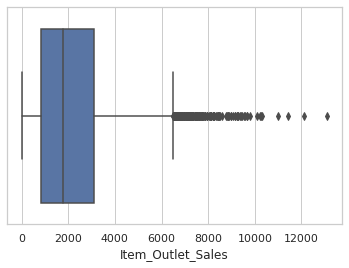

In [ ]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=df["Item_Outlet_Sales"])

In [ ]:
#As we know only Item_Outlet_Sales have outliers we can fix them but fixing them will increase our RMSE score 
#to a large extent

# Plotting Graphs for more Analysis

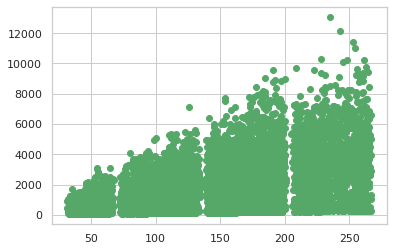

In [ ]:
#value of sales increases for the increase in MRP of the item
plt.scatter(df.Item_MRP,df.Item_Outlet_Sales,c='g')
plt.show()


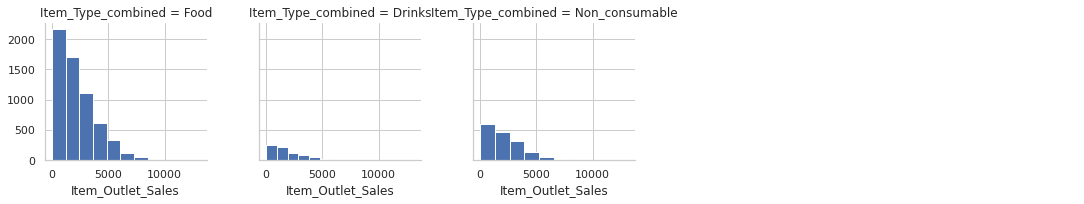

In [ ]:
sns.FacetGrid(df, col='Item_Type_combined', size=3, col_wrap=5) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
# Maximum contribution to outlet sales is from Items that are food type and least is from drinks

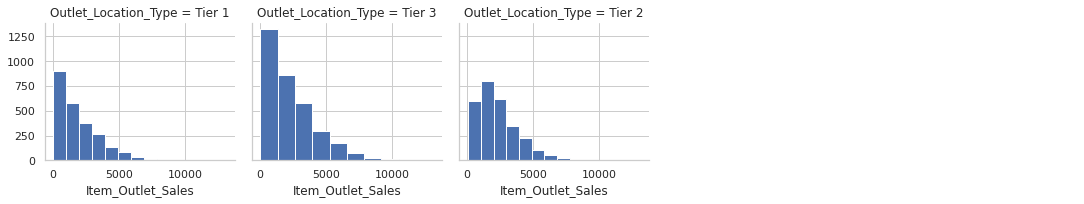

In [ ]:
sns.FacetGrid(df, col='Outlet_Location_Type', size=3, col_wrap=5) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
#Tier3 type of outlet location provides for the maximum sales and other two provides the least sales

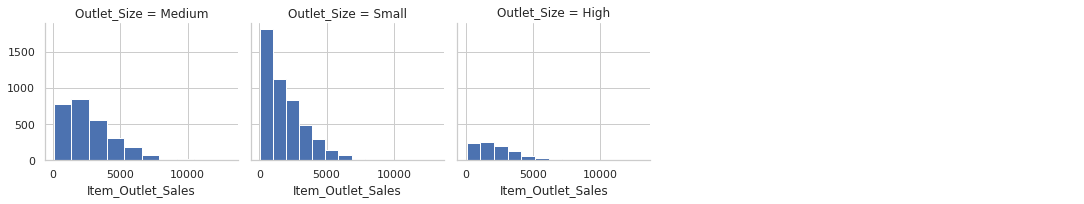

In [ ]:
sns.FacetGrid(df, col='Outlet_Size', size=3, col_wrap=5) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
#Small sized Outlets are providing the maximum sales whereas large sized outlets 
# are contributing the least

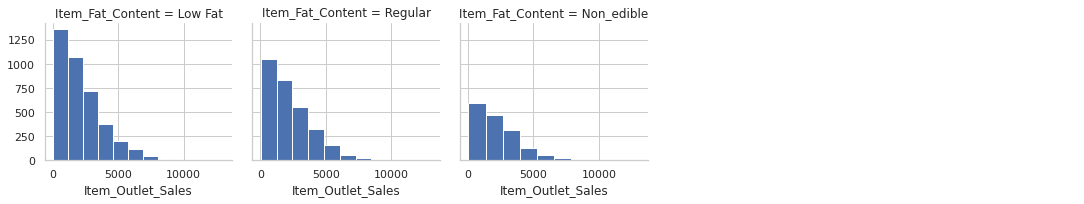

In [ ]:
sns.FacetGrid(df, col='Item_Fat_Content', size=3, col_wrap=5) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
# people are prefering items with lowest fat content the most 

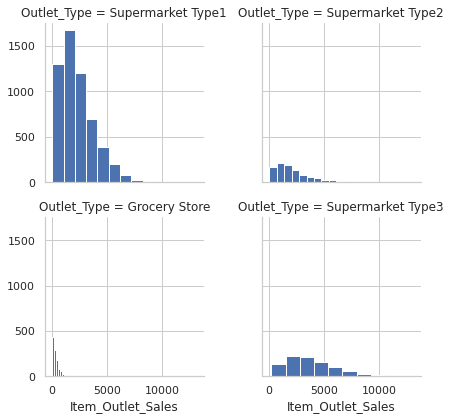

In [ ]:
sns.FacetGrid(df, col='Outlet_Type', size=3, col_wrap=2) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
#Maximum of the high sales margin is from Supermarket Type1
#Grocery store has the least sales

In [ ]:
#Label Encoding all the columns with text entries and dropping Item_identifier  
le=LabelEncoder()
list=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_combined',
      'Outlet_Size']
for i in list:
    le.fit(df[i])
    df[i]=le.transform(df[i])
df_new=df.drop(columns='Item_Identifier')
df_new= pd.get_dummies(df_new,columns=['Outlet_Identifier'])
df_new.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_combined,yearsold,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0,0.016047,249.8092,1,0,1,3735.1380,1,14,0,0,0,0,0,0,0,0,0,1
1,5.92,2,0.019278,48.2692,1,2,2,443.4228,0,4,0,0,0,1,0,0,0,0,0,0
2,17.50,0,0.016760,141.6180,1,0,1,2097.2700,1,14,0,0,0,0,0,0,0,0,0,1
3,19.20,2,0.022930,182.0950,2,2,0,732.3800,1,15,1,0,0,0,0,0,0,0,0,0
4,8.93,1,0.014670,53.8614,0,2,1,994.7052,2,26,0,1,0,0,0,0,0,0,0,0


In [ ]:
#Separating test and train set
df_new_train=df_new.iloc[:8523,:]
df_new_test=df_new.iloc[8523:,:]
df_new_test=df_new_test.drop(columns=['Item_Outlet_Sales'])

In [ ]:
Y_train=df_new_train['Item_Outlet_Sales']
df_train_test=df_new_train.drop(columns=['Item_Outlet_Sales'])

In [ ]:
from sklearn.linear_model import LinearRegression
#Ridge regression or Tikhonov regularization is the regularization technique that performs L2 regularization. It modifies the loss function by adding the penalty (shrinkage quantity) equivalent to the square of the magnitude of coefficients.
from sklearn.linear_model import Ridge
#A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting
from sklearn.ensemble import RandomForestRegressor 
#This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.ensemble import BaggingRegressor

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import ElasticNet 
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
import xgboost as xgb


In [ ]:
models = [('lr',LinearRegression()),('ridge',Ridge()),('rfr',RandomForestRegressor()),('etr',ExtraTreesRegressor()),
         ('br',BaggingRegressor()),('gbr',GradientBoostingRegressor()),('en',ElasticNet()),('mlp',MLPRegressor())]

In [ ]:
#Making function for making best 2 models for further hyperparameter tuning
def basic_model_selection(x,y,cross_folds,model):
    scores=[]
    names = []
    for i , j in model:
        cv_scores = cross_val_score(j, x, y, cv=cross_folds,n_jobs=5)
        scores.append(cv_scores)
        names.append(i)
    for k in range(len(scores)):
        print(names[k],scores[k].mean())

In [ ]:
basic_model_selection(df_train_test,Y_train,4,models)

lr 0.5600132022388752
ridge 0.5600170353227616
rfr 0.553978880657287
etr 0.5231357829052387
br 0.523113398461093
gbr 0.5925840909219284
en 0.47782793794520356
mlp 0.5701189493601961


In [ ]:
#Average score for XGBoost matrix
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=df_train_test,label=Y_train)
# import XGBRegressor
xgb1 = XGBRegressor()
cv_score = cross_val_score(xgb1, df_train_test, Y_train, cv=4,n_jobs=5)
print(cv_score.mean())

0.595114991594813


# Gradient Boost Regression and XGBoost Regression will be used for further hyperparameter tuning

In [ ]:
def model_parameter_tuning(x,y,model,parameters,cross_folds):
    model_grid = GridSearchCV(model,
                        parameters,
                        cv = cross_folds,
                        n_jobs = 5,
                        verbose=True)
    model_grid.fit(x,y)
    y_predicted = model_grid.predict(x)
    print(model_grid.score)
    print(model_grid.best_params_)
    print("The RMSE score is",np.sqrt(np.mean((y-y_predicted)**2)))

#defining function for hyper parameter tuning and using RMSE as my metric
    

In [ ]:
parameters_xgb = {'nthread':[3,4], 
              'learning_rate':[0.02,0.03], #so called `eta` value
              'max_depth': [3,2,4],
              'min_child_weight':[3,4,5],
              'silent': [1],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
              'n_estimators': [300,320]
             }
parameters_gbr={'loss':['ls','lad'],
               'learning_rate':[0.3],
               'n_estimators':[300],
               'min_samples_split':[3,4],
               'max_depth':[3,4],
               'min_samples_leaf':[3,4,2],
               'max_features':['auto','log2','sqrt']
              }

# Defining the useful parameters for parameter tuning
# to get the optimum output

In [ ]:
model_parameter_tuning(df_train_test,Y_train,xgb1,parameters_xgb,4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   51.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 288 out of 288 | elapsed:  5.9min finished


<bound method BaseSearchCV.score of GridSearchCV(cv=4, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.02, 0.03

In [ ]:
gbr=GradientBoostingRegressor()
model_parameter_tuning(df_train_test,Y_train,gbr,parameters_gbr,4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   59.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 288 out of 288 | elapsed:  7.0min finished


<bound method BaseSearchCV.score of GridSearchCV(cv=4, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_it

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp=MLPRegressor()
parameters_mlp = {'hidden_layer_sizes':[300,400,500],
              'activation':['relu','tanh'],
              'learning_rate':['adaptive'],
              'learning_rate_init':[0.001,0.004],
              'solver':['adam'],
              'max_iter':[200,300]
             }

In [ ]:
model_parameter_tuning(df_train_test,Y_train,mlp,parameters_mlp,4)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  7.1min
[Parallel(n_jobs=5)]: Done  96 out of  96 | elapsed: 28.6min finished


<bound method BaseSearchCV.score of GridSearchCV(cv=4, error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=...
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=5,
             param_g

# Standardization of the model before training

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized=scaler.fit_transform(df_train_test)
column_names = df_train_test.columns
df_standardized = pd.DataFrame(data=standardized,columns=column_names)
df_standardized.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_combined,yearsold,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,-0.769246,-0.997813,-1.088101,1.747454,-0.664080,-1.369334,-0.252658,-0.179795,-0.139541,-0.263920,-0.350395,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,2.857362
1,-1.496813,1.236942,-1.023789,-1.489023,-0.664080,1.091569,1.002972,-2.095286,-1.334103,-0.263920,-0.350395,-0.349128,2.860816,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,-0.349973
2,0.995858,-0.997813,-1.073913,0.010040,-0.664080,-1.369334,-0.252658,-0.179795,-0.139541,-0.263920,-0.350395,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,2.857362
3,1.361794,1.236942,-0.951101,0.660050,0.799954,1.091569,-1.508289,-0.179795,-0.020085,3.789031,-0.350395,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,-0.349973
4,-0.848890,0.119565,-1.115522,-1.399220,-2.128115,1.091569,-0.252658,1.735696,1.293934,-0.263920,2.853918,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,-0.349973


In [ ]:
basic_model_selection(df_standardized,Y_train,4,models)

lr 0.5600186236212362
ridge 0.5600139286299949
rfr 0.5522050284491135
etr 0.5248774284369859
br 0.518205371553722
gbr 0.5926980383674245
en 0.5116368076145614
mlp 0.5948507578208453


In [ ]:
#Average score for XGBoost matrix
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=df_standardized,label=Y_train)
# import XGBRegressor
xgb1 = XGBRegressor()
cv_score = cross_val_score(xgb1, df_standardized, Y_train, cv=4,n_jobs=5)
print(cv_score.mean())

0.5951011226638807


# The Models for hyperparameter tuning are same XGBoost and GradientBoostingRegression

In [ ]:
model_parameter_tuning(df_standardized,Y_train,xgb1,parameters_xgb,4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   50.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 288 out of 288 | elapsed:  5.9min finished


<bound method BaseSearchCV.score of GridSearchCV(cv=4, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.02, 0.03

In [ ]:
model_parameter_tuning(df_standardized,Y_train,gbr,parameters_gbr,4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   59.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 288 out of 288 | elapsed:  7.0min finished


<bound method BaseSearchCV.score of GridSearchCV(cv=4, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_it

In [ ]:
df_train_test.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_combined,yearsold,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0,0.016047,249.8092,1,0,1,1,14,0,0,0,0,0,0,0,0,0,1
1,5.92,2,0.019278,48.2692,1,2,2,0,4,0,0,0,1,0,0,0,0,0,0
2,17.50,0,0.016760,141.6180,1,0,1,1,14,0,0,0,0,0,0,0,0,0,1
3,19.20,2,0.022930,182.0950,2,2,0,1,15,1,0,0,0,0,0,0,0,0,0
4,8.93,1,0.014670,53.8614,0,2,1,2,26,0,1,0,0,0,0,0,0,0,0


[texte du lien](https://)# Using Robust Scaler

# My dataset having outliers make it more prone to mistakes
# Robust Scaler handles the outliers as well
# It scales according to the quartile range

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

normalize = MinMaxScaler()
robust = RobustScaler(quantile_range = (0.1,0.8)) #range of inerquartile is one of the parameters
robust_stan = robust.fit_transform(df_train_test)
robust_stan_normalize = normalize.fit_transform(robust_stan)
# also normalized the dataset using MinMaxScaler i.e has bought the data set between (0,1)
df_robust_normalize = pd.DataFrame(robust_stan_normalize,columns=column_names)
df_robust_normalize.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_combined,yearsold,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,0.282525,0.0,0.038399,0.927507,0.5,0.0,0.333333,0.5,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.081274,1.0,0.048346,0.072068,0.5,1.0,0.666667,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.770765,0.0,0.040593,0.468288,0.5,0.0,0.333333,0.5,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.871986,1.0,0.059588,0.640093,1.0,1.0,0.000000,0.5,0.458333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.260494,0.5,0.034158,0.095805,0.0,1.0,0.333333,1.0,0.916667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
basic_model_selection(df_robust_normalize,Y_train,4,models)

lr 0.560009026652901
ridge 0.5600208310827125
rfr 0.55045420860889
etr 0.5212283119599912
br 0.5160675766673948
gbr 0.5925386817528885
en 0.16450894691039902
mlp 0.4962109616556029


In [ ]:
cv_score = cross_val_score(xgb1, df_robust_normalize, Y_train, cv=4,n_jobs=5)
print(cv_score.mean())

0.5951011226638807


In [ ]:
model_parameter_tuning(df_robust_normalize,Y_train,xgb1,parameters_xgb,4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   50.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 288 out of 288 | elapsed:  5.9min finished


<bound method BaseSearchCV.score of GridSearchCV(cv=4, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.02, 0.03

In [ ]:
model_parameter_tuning(df_robust_normalize,Y_train,gbr,parameters_gbr,4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 288 out of 288 | elapsed:  7.1min finished


<bound method BaseSearchCV.score of GridSearchCV(cv=4, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_it

# Best Model 
# Comparing all models using RMSE score 


# Gradient Boosting Method is the best method when implemented using Robust Scaler and MinMaxScaler normalization
 PARAMETERS AND RMSE RESPECTIVELY
 {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
The RMSE score is 1049.14085875651

In [147]:
robust_test = robust.fit_transform(df_new_test)
robust_normalize_test = normalize.fit_transform(robust_test)
df_test_robust_normalize = pd.DataFrame(robust_normalize_test,columns=column_names)

In [148]:
gbr = GradientBoostingRegressor(learning_rate= 0.3, loss= 'lad',max_depth= 3,min_samples_leaf=2,min_samples_split=3
                                ,n_estimators= 300)
# Defining my final model that I will use for prediction

In [149]:
gbr.fit(df_robust_normalize,Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='lad', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [150]:
final_prediction=gbr.predict(df_test_robust_normalize) #Predicting the outlet sales

In [151]:
#the prediction is in the form of numpy array 
# Converting into Dataframe 
df_final_prediction = pd.DataFrame(final_prediction,columns=['Item_Outlet_Sales'])

In [152]:
df_final_prediction.head()

,Item_Outlet_Sales
0,1685.263773
1,1280.670388
2,554.036778
3,2489.002710
4,5875.087556


# Saving the final model using Joblib

In [153]:
import joblib
filename = 'final_model.sav' # Name of the model 
joblib.dump(gbr, filename) # it is saved in your current working directory

['final_model.sav']

In [154]:
# This command loads the model once again
load_model = joblib.load(filename)